In [1]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.time import Time
import astropy.units as u
import glob

In [2]:
rcParams.update({'font.size': 14})

In [3]:
t = Table.read('../data/10700_activity.csv')

In [4]:
t.columns

<TableColumns names=('File','Time [MJD]','Epoch','SNR','CBC RV [m/s]','CBC RV Err. [m/s]','CCF RV [m/s]','CCF RV Err. [m/s]','S Value','H-alpha Emission','H-alpha Equiv. Width [A]','CCF FWHM [m/s]','CCF FWHM Err. [m/s]','BIS [m/s]','V_span [m/s]','Bi-Gaussian [m/s]','Skew Normal','Date Generated','Phot. GP [mag]','Phot. GP Err. [mag]')>

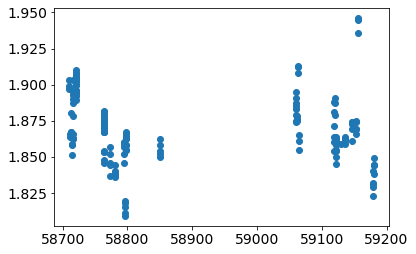

In [5]:
plt.scatter(t['Time [MJD]'], t['H-alpha Equiv. Width [A]']);

2020-07-31T11:34:38.496


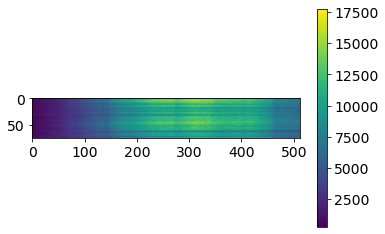

In [6]:
i = 120
print(Time(t['Time [MJD]'][i], format = 'mjd').isot)
with fits.open('../data/10700_spectra/{}'.format(t['File'][i])) as hdus:
    plt.imshow(hdus[2].data['expm_specs'][2:-2].astype(np.uint16))
    plt.colorbar();

In [7]:
#start_ind, end_ind = 26,46
#start_ind,end_ind = 40,150
start_ind, end_ind = 130,170
time = np.copy(t['Time [MJD]'][start_ind:end_ind])
rv = np.copy(t['CBC RV [m/s]'][start_ind:end_ind])

In [8]:
halpha_emission = t['H-alpha Emission'][start_ind:end_ind]
halpha_ew = t['H-alpha Equiv. Width [A]'][start_ind:end_ind]

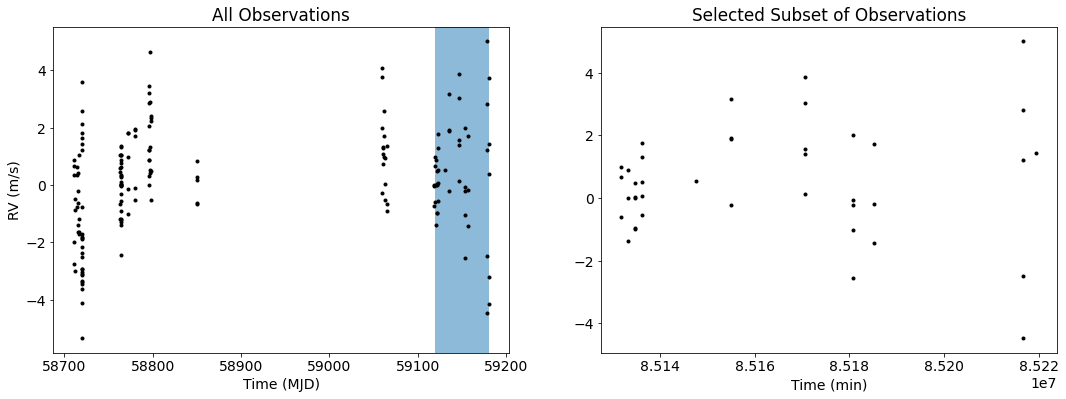

In [9]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
ax1.plot(t['Time [MJD]'], t['CBC RV [m/s]'], 'k.')
ax1.axvspan(t['Time [MJD]'][start_ind], t['Time [MJD]'][end_ind-1], alpha=0.5)
ax1.set_ylabel('RV (m/s)')
ax1.set_xlabel('Time (MJD)')
ax2.plot(time*24.*60., rv, 'k.')
ax2.set_xlabel('Time (min)')
ax1.set_title('All Observations')
ax2.set_title('Selected Subset of Observations');

In [10]:
n_frames = len(time)
airmass = np.zeros(n_frames)
pwv = np.zeros_like(airmass)  # precipitable water vapor
moondist = np.zeros_like(airmass)
exptime = np.zeros_like(airmass)
adcstat = np.zeros_like(airmass, dtype='object')
for i,f in enumerate(t['File'][start_ind:end_ind]):
    with fits.open('../data/10700_spectra/{}'.format(f)) as hdus:
        airmass[i] = hdus[0].header['AIRMASS']
        pwv[i] = hdus[1].header['PWV']
        moondist[i] = hdus[0].header['MOONDIST']
        exptime[i] = hdus[0].header['AEXPTIME']
        try: 
            adcstat[i] = hdus[0].header['ADCSTAT']
        except KeyError:
            continue

In [11]:
micro_time = np.array([])
frame_idx = np.array([], dtype=np.uint8)
micro_wave = np.array([])
micro_flux = np.array([], dtype=np.uint16)
seconds_per_day = 86400.
micro_pixels = 512
for i,f in enumerate(t['File'][start_ind:end_ind]):
    with fits.open('../data/10700_spectra/{}'.format(f)) as hdus:
        tt = time[i] + hdus[2].data['midpoints'][2:-2] / seconds_per_day
        ww = hdus[2].data['wavelengths'][2:-2].ravel()
        ff = hdus[2].data['expm_specs'][2:-2].ravel().astype(np.uint16)
        frame_idx = np.concatenate([frame_idx, np.zeros(len(tt)) + i])
        micro_time = np.concatenate([micro_time, tt])
        micro_wave = np.concatenate([micro_wave, ww])
        micro_flux = np.concatenate([micro_flux, ff])


micro_wave = micro_wave.reshape((-1,micro_pixels))
micro_flux = micro_flux.reshape((-1,micro_pixels))

In [12]:
micro_flux.shape

(3436, 512)

In [13]:
micro_flux = micro_flux.astype(np.uint32)

#### these images should be the same if i didn't screw up:

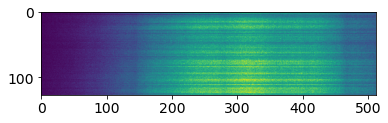

In [14]:
frame = 0
plt.imshow(micro_flux[frame_idx == frame])

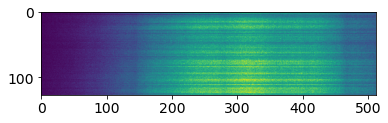

In [15]:
f = t['File'][start_ind + frame]
with fits.open('../data/10700_spectra/{}'.format(f)) as hdus:
    plt.imshow(hdus[2].data['expm_specs'][2:-2].astype(np.uint16))

#### plots:

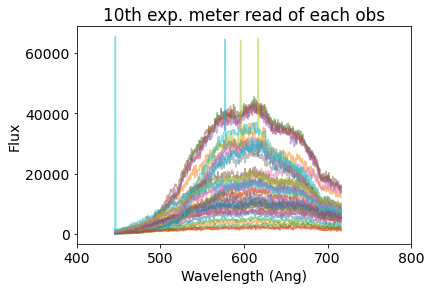

In [16]:
micro_frame = 10
for i in range(n_frames):
    plt.plot(micro_wave[frame_idx == i][micro_frame,:],
             micro_flux[frame_idx == i][micro_frame,:], alpha=0.5)
plt.xlabel('Wavelength (Ang)')
plt.ylabel('Flux')
plt.title('{0}th exp. meter read of each obs'.format(micro_frame))
plt.xlim([400,800]);

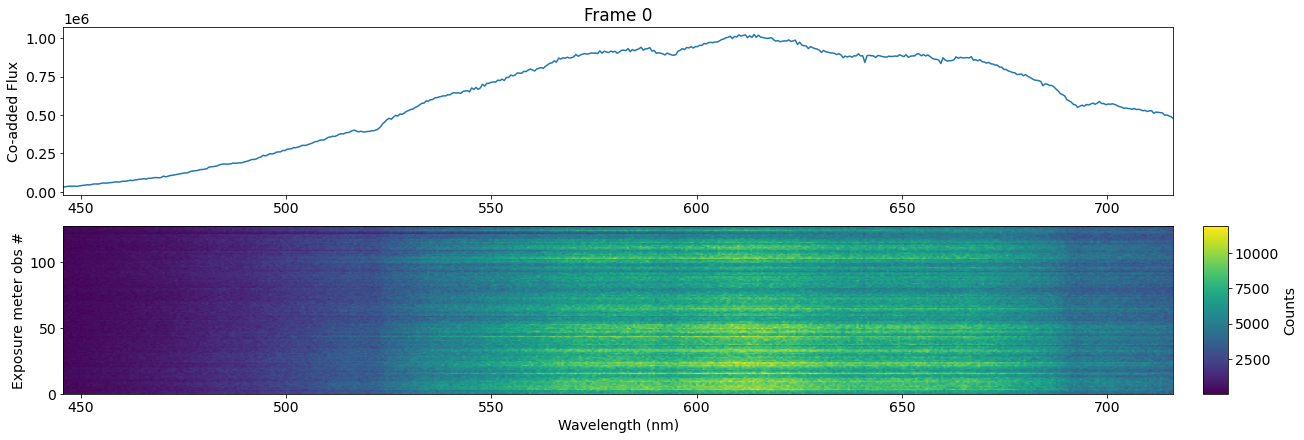

In [114]:
frame = 0

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18,6), gridspec_kw={'hspace':0.3}, constrained_layout=True)
ax1.plot(micro_wave[frame_idx == frame][0], np.sum(micro_flux[frame_idx == frame], axis=0))
ax1.set_xlim([micro_wave[0,0], micro_wave[0,-1]])
im = ax2.imshow(micro_flux[frame_idx == frame], extent=(micro_wave[0,0], micro_wave[0,-1], 0, np.shape(micro_flux[frame_idx == frame])[0]), aspect='auto')
plt.colorbar(im, ax=ax2, label='Counts')
ax2.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Co-added Flux')
ax2.set_ylabel('Exposure meter obs #')
ax1.set_title('Frame {0}'.format(frame));

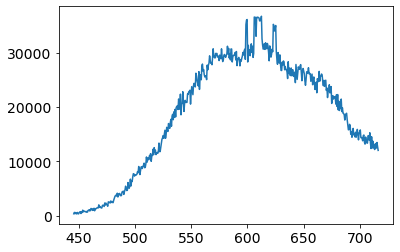

In [113]:
plt.plot(micro_wave[0], micro_flux[frame_idx == 11][10,:]);

In [85]:
np.shape(micro_flux)

(3436, 512)

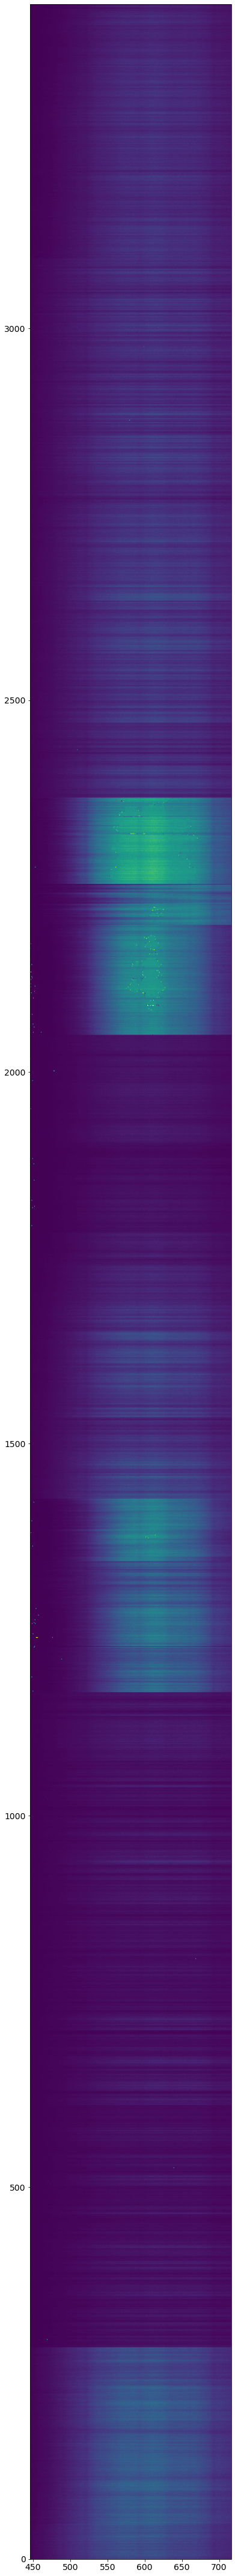

In [91]:
fig, ax = plt.subplots(1,1, figsize=(6,90))
ax.imshow(micro_flux, extent=(micro_wave[0,0], micro_wave[0,-1], 0, np.shape(micro_flux)[0]));

#### look at frame-level time series:

In [18]:
grad_idx = np.where(np.diff(frame_idx) == 1)[0] + 1 # idx where the frame increments

In [19]:
frames = np.array_split(micro_flux, grad_idx)

In [20]:
halpha_pix = np.where((micro_wave[0] > 640.) & (micro_wave[0] < 660.))[0]

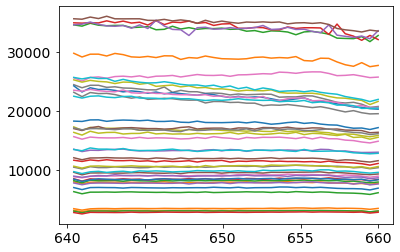

In [21]:
for frame in frames:
    plt.plot(micro_wave[0,halpha_pix], np.mean(frame[:, halpha_pix], axis=0))

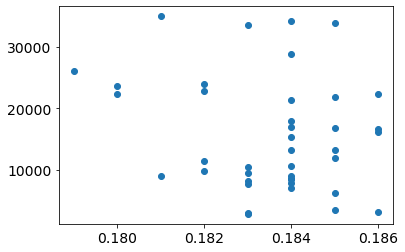

In [22]:
plt.scatter(halpha_emission, [frame[:, halpha_pix].mean() for frame in frames]);

In [23]:
from scipy.stats import pearsonr
pearsonr(halpha_emission, [frame[:, halpha_pix].std() for frame in frames])

(-0.18343603941579278, 0.25721032345107403)

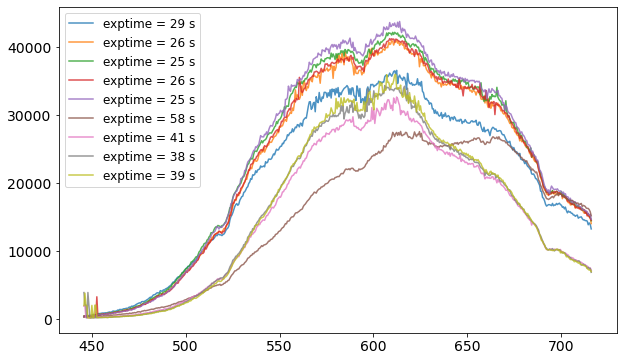

In [122]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
for i,frame in enumerate(frames):
    if (i>10) & (i<20):  # don't judge me
        this_frame_avg = np.mean(frame, axis=0)
        #this_frame_avg /= this_frame_avg.mean()
        #plt.plot(micro_wave[0], this_frame_avg, alpha=0.5, label='{0}'.format(Time(t['Time [MJD]'][i+start_ind], format = 'mjd').isot))
        ax.plot(micro_wave[0], this_frame_avg, alpha=0.8, label='exptime = {0:.0f} s'.format(exptime[i]))
        ax.legend(fontsize=12);

#### make some periodograms:

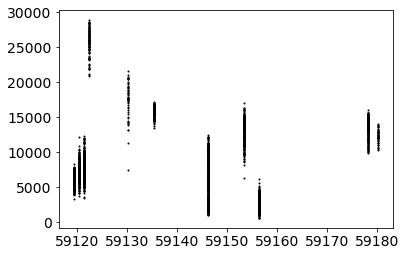

In [25]:
plt.plot(micro_time.ravel(), np.median(micro_flux, axis=1), 'k.', ms=2)
plt.xlim();

In [26]:
time_jd = Time(micro_time, format='mjd')

In [27]:
import lightkurve as lk
christina = lk.LightCurve(time=time_jd, flux=np.median(micro_flux[:,:256], axis=1))

In [28]:
ls = christina.to_periodogram(oversample_factor=0.1,
                             freq_unit = u.Hz)

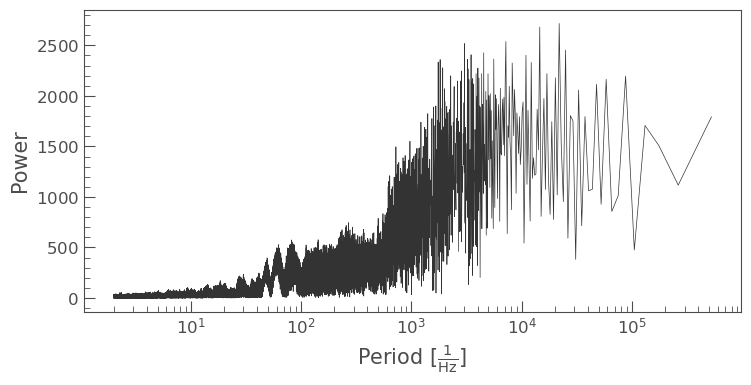

In [29]:
ax = ls.plot(view='period')
#ax.axvline(ls.period_at_max_power.value, linewidth=1, alpha=0.5)
ax.set_xscale('log');

In [30]:
megan = christina.copy()
#megan.flux = np.random.normal(christina.flux.mean(), christina.flux.std(), christina.flux.shape[0])
megan.flux = christina.flux * 0 + np.mean(christina.flux)

In [31]:
ls_noise = megan.to_periodogram(oversample_factor=0.1,
                             freq_unit = u.Hz)

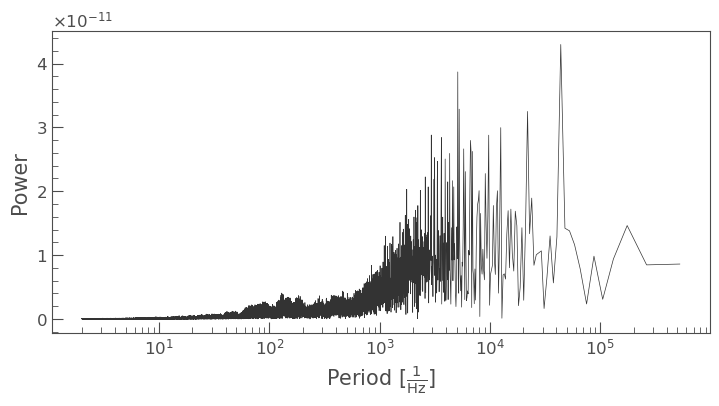

In [32]:
ax = ls_noise.plot(view='period')
#ax.axvline(ls_noise.period_at_max_power.value, linewidth=1, alpha=0.5)
ax.set_xscale('log');

In [33]:
norm_factor = np.median(ls.power / ls_noise.power)
print(norm_factor)

377302684461719.9


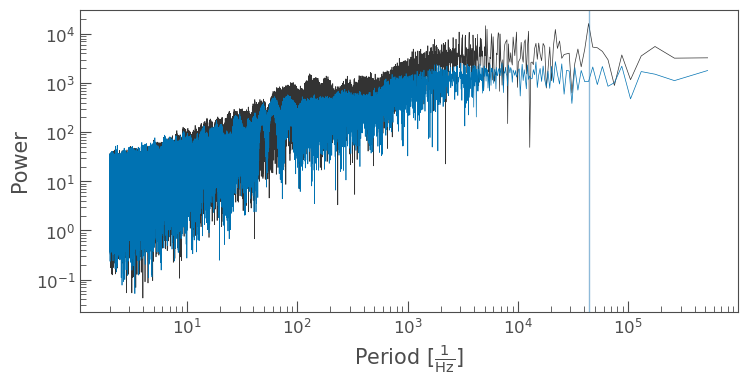

In [34]:
ax = (ls_noise * norm_factor).plot(view='period')
ls.plot(ax = ax, view='period')
ax.axvline(ls_noise.period_at_max_power.value, linewidth=1, alpha=0.5)
ax.set_yscale('log')
ax.set_xscale('log');

#### remove major trends from the exposure meter data:

In [35]:
avg = np.median(micro_flux, axis=0)
avg /= avg.mean()

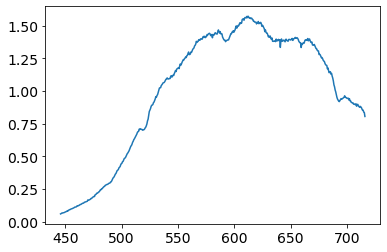

In [36]:
plt.plot(micro_wave[0], avg);

intra-night RV scatter -- compare to scaling factor, cloudiness (skew?)
single-channel barycentric correction time -- exposure meter header kws
exposure time and barycentric correction correlations? (showing that clouds dominate rather than airmass)

In [39]:
from scipy import sparse

In [117]:
n_spectra = micro_flux.shape[0]
diag = sparse.diags(np.ones(n_spectra), format='lil')
sparse_stack = lambda x: sparse.vstack([x] * micro_pixels, format='lil').reshape([1,micro_pixels * n_spectra])
X = sparse.vstack([sparse_stack(d) for d in diag[0:10]])

In [118]:
X.shape

(10, 1759232)